In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings
import statsmodels.api as sm
import pickle
from datetime import datetime
from dateutil.parser import parse
warnings.filterwarnings('ignore')

%matplotlib inline

In [365]:
df_air = pickle.load(open('df_air2.p', 'rb'))

In [366]:
df_air = df_air.sort_values(['air_store_id', 'visit_date'])
df_air.index = df_air.visit_date

In [468]:
df_air_first = df_air[df_air.air_store_id == 'air_900d755ebd2f7bbd']

### Plot restaurant visits

air_ba937bf13d40fb24, 'air_0164b9927d20bcc3', 'air_0241aa3964b7f861'

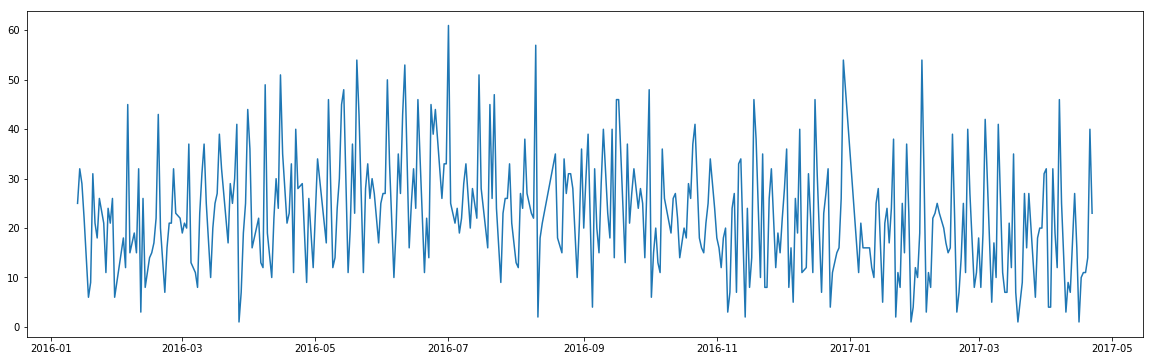

In [261]:
plt.subplots(1,1,figsize=(20,6))
plt.plot(df_air_first.index, df_air_first.visitors)

### AR model

In [194]:
def plot_ar_model(data, model, ar_value, restaurant_name):

    x = data.index
    y_true = data.visitors

    #plot actual usage
    plt.subplots(1,1,figsize=(20,6))
    plt.plot(x,y_true, label='Visitors')

    x_pred = x[ar_value:]
    y_pred = model.predict()

    #plot model prediction with AR
    plt.plot(x_pred,y_pred, color='red', label='AR')

    plt.title("Visits to Restaurant {} AR-{}".format(restaurant_name, ar_value))
    plt.xlabel("Date-Time", fontsize=16)
    plt.ylabel("Visitors", fontsize=16)
    plt.legend()

AR-7

In [195]:
AR7_model = sm.tsa.AR(df_air_first.visitors, freq=None).fit(maxlag=7)
print(AR7_model.params)

LinAlgError: SVD did not converge

ValueError: x and y must have same first dimension, but have shapes (150,) and (384,)

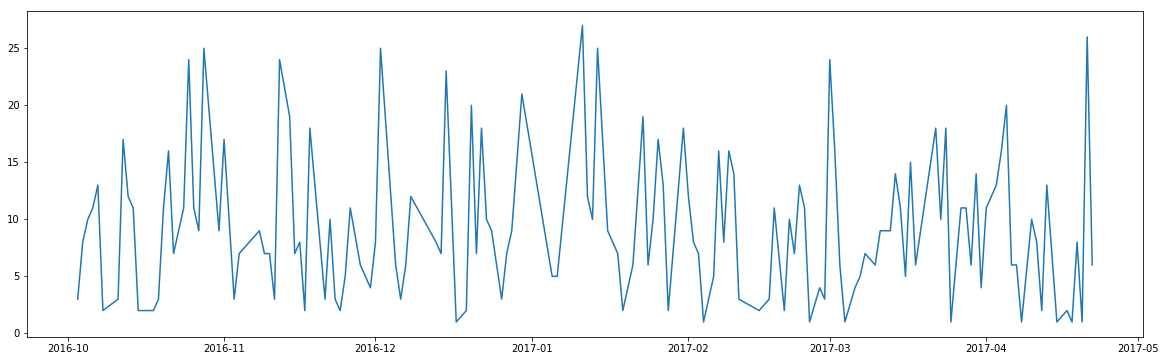

In [160]:
plot_ar_model(df_air_first, AR7_model, 7, 'air_ba937bf13d40fb24')

### ARIMA model

In [196]:
from datetime import datetime, timedelta
from dateutil.relativedelta import *
import statsmodels.tsa.api as smt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [458]:
arima = sm.tsa.statespace.SARIMAX(df_air_first.visitors,
                                  trend=None,
                                  order=(7,0,7),
                                  seasonal_order=(1,1,1,7),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False).fit()

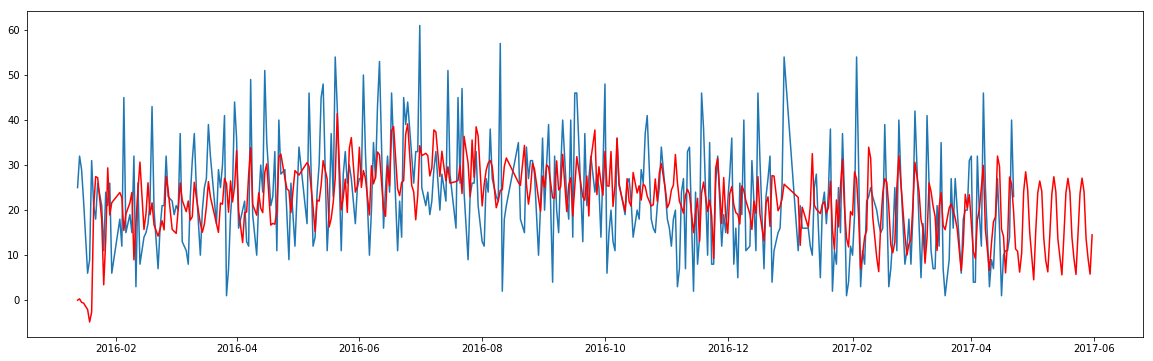

In [459]:
plt.subplots(1,1,figsize=(20,6))
plt.plot(df_air_first.index, df_air_first.visitors, label='Visitors')
plt.plot(df_air_first.index, arima.predict(), color='red', label='ARIMA')

## Add exogenous variables

In [469]:
exogenous = df_air_first.loc[:,['holiday_flg','Monday','Tuesday','Wednesday','Thursday','Friday',
                                'Saturday']].astype(float)
endogenous = df_air_first.loc[:,'visitors'].astype(float)

In [472]:
sarimax_model = sm.tsa.statespace.SARIMAX(endog=endogenous,
                                  exog = exogenous,
                                  trend=None,
                                  order=(1,0,0),
                                  seasonal_order=(1,0,0,7),
                                  enforce_stationarity=True,
                                  enforce_invertibility=False).fit()

In [473]:
start_date = datetime(2017,4,22)
end_date = datetime(2017,5,31)

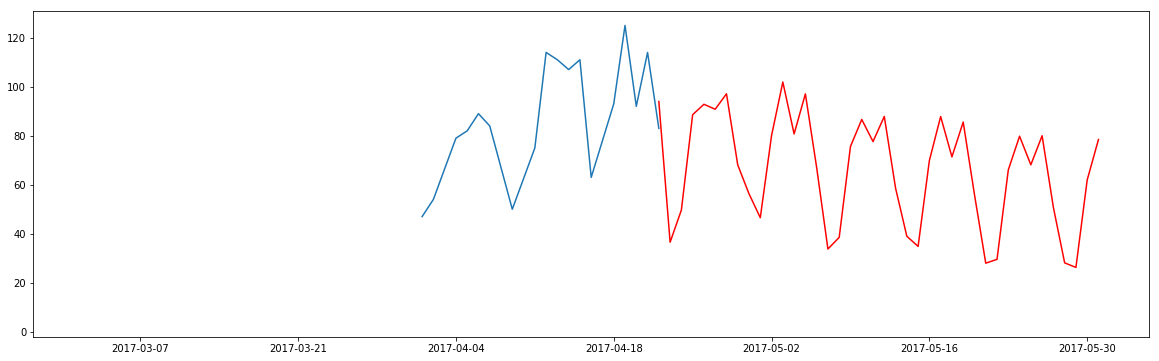

In [474]:
plt.subplots(1,1,figsize=(20,6))
plt.plot(df_air_first.index, df_air_first.visitors, label='Visitors')
plt.plot(df_air_first.loc[start_date.date():end_date.date(),:].index, sarimax_model.predict(start_date,end_date), color='red', label='SARIMAX')

## Create predictions

In [505]:
#function to fit sarimax model for a store
def get_sarimax(data, store):
    
    df = data[data.air_store_id==store]
    exogenous = df.loc[:,['holiday_flg','Monday','Tuesday','Wednesday','Thursday','Friday',
                                'Saturday']].astype(float)
    endogenous = df.loc[:,'visitors'].astype(float)
    
    if df.shape[0] > 100:
        sarimax_model = sm.tsa.statespace.SARIMAX(endog=endogenous,
                                      exog = exogenous,
                                      trend=None,
                                      order=(2,0,2),
                                      seasonal_order=(1,1,0,7),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False).fit()
    else:
        sarimax_model = sm.tsa.statespace.SARIMAX(endog=endogenous,
                                      exog = exogenous,
                                      trend=None,
                                      order=(1,0,0),
                                      seasonal_order=(1,0,0,7),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False).fit()
    
    start_date = df.shape[0] - 40
    end_date = df.shape[0] -1
    
    df.iloc[-39:,4] = sarimax_model.predict(start_date,end_date).astype(int)
    
    return df

In [506]:
get_sarimax(df_air, 'air_00a91d42b08b08d9').iloc[-39:,:]

,air_store_id,visit_date,air_reserve_visitors,hpg_reserve_visitors,visitors,holiday_flg,air_genre_name,hpg_genre_name,air_area_name,latitude,...,Chinese,Western,Asian,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
visit_date,,,,,,,,,,,,,,,,,,,,,
2017-04-23,air_00a91d42b08b08d9,2017-04-23,NaN,NaN,3.0,0,Italian/French,,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,1,0,0,0,0,1,0,0,0
2017-04-24,air_00a91d42b08b08d9,2017-04-24,NaN,NaN,9.0,0,Italian/French,,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,1,0,0,1,0,0,0,0,0
2017-04-25,air_00a91d42b08b08d9,2017-04-25,NaN,NaN,24.0,0,Italian/French,,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,1,0,0,0,0,0,0,1,0
2017-04-26,air_00a91d42b08b08d9,2017-04-26,NaN,NaN,20.0,0,Italian/French,,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,1,0,0,0,0,0,0,0,1
2017-04-27,air_00a91d42b08b08d9,2017-04-27,NaN,NaN,44.0,0,Italian/French,,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,1,0,0,0,0,0,1,0,0
2017-04-28,air_00a91d42b08b08d9,2017-04-28,NaN,NaN,43.0,0,Italian/French,,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,1,0,1,0,0,0,0,0,0
2017-04-29,air_00a91d42b08b08d9,2017-04-29,NaN,NaN,14.0,1,Italian/French,,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,1,0,0,0,1,0,0,0,0
2017-04-30,air_00a91d42b08b08d9,2017-04-30,NaN,NaN,4.0,0,Italian/French,,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,1,0,0,0,0,1,0,0,0
2017-05-01,air_00a91d42b08b08d9,2017-05-01,NaN,NaN,14.0,0,Italian/French,,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,1,0,0,1,0,0,0,0,0


In [512]:
#function to make prediction for each restaurant and concat to prediction dataframe
def create_predictions(data):
    
    df = data[data.air_store_id == 'air_00a91d42b08b08d9']
    df = get_sarimax(df, 'air_00a91d42b08b08d9').iloc[-39:,:]
    
    for store in data.air_store_id.unique()[1:]:
        df_add = data[data.air_store_id==store]
        print('Restaurant {} is done'.format(store))
        df = pd.concat([df, get_sarimax(df_add, store).iloc[-39:,:]])
        
    return df

In [513]:
df_air[df_air.air_store_id=='air_900d755ebd2f7bbd'].shape

(78, 27)

In [514]:
np.where(df_air.air_store_id.unique()=='air_900d755ebd2f7bbd')

(array([453]),)

In [515]:
df_air.air_store_id.unique()[454]

'air_901925b628677c2e'

In [516]:
df_predictions = create_predictions(df_air)

Restaurant air_0164b9927d20bcc3 is done
Restaurant air_0241aa3964b7f861 is done
Restaurant air_0328696196e46f18 is done
Restaurant air_034a3d5b40d5b1b1 is done
Restaurant air_036d4f1ee7285390 is done
Restaurant air_0382c794b73b51ad is done
Restaurant air_03963426c9312048 is done
Restaurant air_04341b588bde96cd is done
Restaurant air_049f6d5b402a31b2 is done
Restaurant air_04cae7c1bc9b2a0b is done
Restaurant air_0585011fa179bcce is done
Restaurant air_05c325d315cc17f5 is done
Restaurant air_0647f17b4dc041c8 is done
Restaurant air_064e203265ee5753 is done
Restaurant air_066f0221b8a4d533 is done
Restaurant air_06f95ac5c33aca10 is done
Restaurant air_0728814bd98f7367 is done
Restaurant air_0768ab3910f7967f is done
Restaurant air_07b314d83059c4d2 is done
Restaurant air_07bb665f9cdfbdfb is done
Restaurant air_082908692355165e is done
Restaurant air_083ddc520ea47e1e is done
Restaurant air_0845d8395f30c6bb is done
Restaurant air_084d98859256acf0 is done
Restaurant air_0867f7bebad6a649 is done


Restaurant air_4570f52104fe0982 is done
Restaurant air_4579cb0669fd411b is done
Restaurant air_457efe8c3a30ea17 is done
Restaurant air_464a62de0d57be1e is done
Restaurant air_465bddfed3353b23 is done
Restaurant air_47070be6093f123e is done
Restaurant air_472b19e3b5bffa41 is done
Restaurant air_473cf23b9e7c0a37 is done
Restaurant air_473f98b212d37b4a is done
Restaurant air_47beaffd3806c979 is done
Restaurant air_483eba479dc9910d is done
Restaurant air_48e9fc98b62495a7 is done
Restaurant air_48f4da6223571da4 is done
Restaurant air_48ffd31594bc3263 is done
Restaurant air_49211568cab5fdee is done
Restaurant air_4974785f48853db9 is done
Restaurant air_4b251b9f8373f1ae is done
Restaurant air_4b380b4db9d37883 is done
Restaurant air_4b55d8aea1d2b395 is done
Restaurant air_4b9085d0d46a6211 is done
Restaurant air_4beac252540f865e is done
Restaurant air_4c2ed28f3f19ca52 is done
Restaurant air_4c665a2bfff0da3b is done
Restaurant air_4c727b55acdee495 is done
Restaurant air_4cab15ad29c0ffbc is done


Restaurant air_832f9dbe9ee4ebd3 is done
Restaurant air_83db5aff8f50478e is done
Restaurant air_84060403939d8216 is done
Restaurant air_848616680ef061bd is done
Restaurant air_84f6876ff7e83ae7 is done
Restaurant air_8523d6a70de49e6c is done
Restaurant air_859feab8e3c9f98d is done
Restaurant air_85bd13a49370c392 is done
Restaurant air_86cfbf2624576fad is done
Restaurant air_86f7b2109e4abd65 is done
Restaurant air_87059630ab6fe47f is done
Restaurant air_87078cf7903a648c is done
Restaurant air_87467487d21891dd is done
Restaurant air_8764b3473ddcceaf is done
Restaurant air_876d7a23c47811cb is done
Restaurant air_877f79706adbfb06 is done
Restaurant air_87ca98aa7664de94 is done
Restaurant air_87f9e1024b951f01 is done
Restaurant air_883ca28ef0ed3d55 is done
Restaurant air_88c8e34baa79217b is done
Restaurant air_88ca84051ba95339 is done
Restaurant air_88f31db64991768a is done
Restaurant air_890d7e28e8eaaa11 is done
Restaurant air_89e7328af22efe74 is done
Restaurant air_8a1d21fad48374e8 is done


Restaurant air_bed603c423b7d9d4 is done
Restaurant air_bedd35489e666605 is done
Restaurant air_bf13014b6e3e60ca is done
Restaurant air_bf21b8350771879b is done
Restaurant air_bf617aa68d5f1cfa is done
Restaurant air_bf7591560077332d is done
Restaurant air_bfafaed35e213fd7 is done
Restaurant air_bfda7731a6c6fc61 is done
Restaurant air_c027e2b560442808 is done
Restaurant air_c0385db498b391e5 is done
Restaurant air_c1d5d165c055b866 is done
Restaurant air_c1ff20617c54fee7 is done
Restaurant air_c225148c0fcc5c72 is done
Restaurant air_c2626f5f86d57342 is done
Restaurant air_c26f027b5bc1f081 is done
Restaurant air_c28983412a7eefcf is done
Restaurant air_c2c8435bdb3516d4 is done
Restaurant air_c31472d14e29cee8 is done
Restaurant air_c3585b0fba3998d0 is done
Restaurant air_c3bc011cca3bec65 is done
Restaurant air_c3dcaf3aeb18e20e is done
Restaurant air_c47aa7493b15f297 is done
Restaurant air_c4fa5c562d5409ca is done
Restaurant air_c52c63c781fe48f6 is done
Restaurant air_c5459218282bedd5 is done


Restaurant air_fdcfef8bd859f650 is done
Restaurant air_fe22ef5a9cbef123 is done
Restaurant air_fe58c074ec1445ea is done
Restaurant air_fea5dc9594450608 is done
Restaurant air_fee8dcf4d619598e is done
Restaurant air_fef9ccb3ba0da2f7 is done
Restaurant air_ffcc2d5087e1b476 is done
Restaurant air_fff68b929994bfbd is done


In [534]:
# pickle.dump(df_predictions, open('df_predictions.p','wb'))
df_predictions = pickle.load(open('df_predictions.p', 'rb'))

In [489]:
filepath = '../inputs/'
sample_submission = pd.read_csv(filepath + 'sample_submission.csv')

In [491]:
sample_submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


In [535]:
df_predictions['id'] = df_predictions['air_store_id'] + '_' + df_predictions['visit_date'].astype(str)

In [537]:
df_predictions = df_predictions[['id','visitors']]
df_predictions = df_predictions.reset_index().drop('visit_date', axis=1)

In [538]:
df_predictions.shape

(32331, 2)

In [540]:
df_air[df_air.air_store_id=='air_0ead98dd07e7a82a']

,air_store_id,visit_date,air_reserve_visitors,hpg_reserve_visitors,visitors,holiday_flg,air_genre_name,hpg_genre_name,air_area_name,latitude,...,Chinese,Western,Asian,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
visit_date,,,,,,,,,,,,,,,,,,,,,
2016-07-02,air_0ead98dd07e7a82a,2016-07-02,NaN,NaN,3.0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
2016-07-04,air_0ead98dd07e7a82a,2016-07-04,NaN,NaN,12.0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
2016-07-07,air_0ead98dd07e7a82a,2016-07-07,NaN,NaN,5.0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
2016-07-08,air_0ead98dd07e7a82a,2016-07-08,NaN,NaN,1.0,0,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
2016-07-11,air_0ead98dd07e7a82a,2016-07-11,NaN,NaN,2.0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
2016-07-12,air_0ead98dd07e7a82a,2016-07-12,NaN,NaN,9.0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0
2016-07-13,air_0ead98dd07e7a82a,2016-07-13,NaN,NaN,2.0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
2016-07-14,air_0ead98dd07e7a82a,2016-07-14,NaN,NaN,17.0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
2016-07-19,air_0ead98dd07e7a82a,2016-07-19,NaN,NaN,51.0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0


In [543]:
row_delete = list(set(df_predictions.id) - set(df_predictions.id).intersection(set(sample_submission.id)))

In [552]:
df_predictions = df_predictions.drop(df_predictions[df_predictions.id.isin(row_delete)].index, axis=0).reset_index()

In [555]:
df_predictions.drop('index',axis=1,inplace=True)

In [578]:
df_predictions.loc[:,'visitors'] = df_predictions.apply(
    lambda row: row['visitors'] if row['visitors']>0 else 0, axis=1)

In [579]:
df_predictions.to_csv('submission_012918.csv', index=False)

In [573]:
sample_submission.visitors[0]

numpy.int64

In [529]:
sample_submission.shape

(32019, 2)